In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def data_reading():
    # Read dataset
    df = pd.read_csv("data/breast-cancer-wisconsin.data", header=None)
    # Check dataframe
    print("\n--------------- Data describe ---------------\n")
    print(df.describe())
    return df


In [3]:
def plot_roc_curve(fper, tper, model, k, i, temp, scaler):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.subplot(k, i,temp)
    plt.subplots_adjust(wspace=0.5, hspace=2)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.title('%s scaled %s best acc / %d fold'  %(model,scaler,k))
    #plt.legend()

In [4]:
# Read dataset
df = data_reading()


--------------- Data describe ---------------

                 0           1           2           3           4   \
count  6.990000e+02  699.000000  699.000000  699.000000  699.000000   
mean   1.071704e+06    4.417740    3.134478    3.207439    2.806867   
std    6.170957e+05    2.815741    3.051459    2.971913    2.855379   
min    6.163400e+04    1.000000    1.000000    1.000000    1.000000   
25%    8.706885e+05    2.000000    1.000000    1.000000    1.000000   
50%    1.171710e+06    4.000000    1.000000    1.000000    1.000000   
75%    1.238298e+06    6.000000    5.000000    5.000000    4.000000   
max    1.345435e+07   10.000000   10.000000   10.000000   10.000000   

               5           7           8           9           10  
count  699.000000  699.000000  699.000000  699.000000  699.000000  
mean     3.216023    3.437768    2.866953    1.589413    2.689557  
std      2.214300    2.438364    3.053634    1.715078    0.951273  
min      1.000000    1.000000    1.00000

In [5]:
# Data Preprocessing
# Name columns
df.columns = ['ID', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
                  'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses',
                  'Class']
print("\n--------------- Print data ---------------\n")
print(df)


--------------- Print data ---------------

          ID  Clump Thickness  Uniformity of Cell Size  \
0    1000025                5                        1   
1    1002945                5                        4   
2    1015425                3                        1   
3    1016277                6                        8   
4    1017023                4                        1   
..       ...              ...                      ...   
694   776715                3                        1   
695   841769                2                        1   
696   888820                5                       10   
697   897471                4                        8   
698   897471                4                        8   

     Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
0                           1                  1                            2   
1                           4                  5                            7   
2              

In [6]:
# Find NAN and drop it
print("\n---------------Find NAN ---------------\n")
df = df.replace('?', np.NaN)
print(df.isnull().sum())


---------------Find NAN ---------------

ID                              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64


In [8]:
print("\n--------------- Drop NAN and check data ---------------\n")
df.dropna(inplace=True)
print(df)


--------------- Drop NAN and check data ---------------

          ID  Clump Thickness  Uniformity of Cell Size  \
0    1000025                5                        1   
1    1002945                5                        4   
2    1015425                3                        1   
3    1016277                6                        8   
4    1017023                4                        1   
..       ...              ...                      ...   
694   776715                3                        1   
695   841769                2                        1   
696   888820                5                       10   
697   897471                4                        8   
698   897471                4                        8   

     Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
0                           1                  1                            2   
1                           4                  5                            7   
2 

In [9]:
# Drop 'ID' because we don't need it
df.drop('ID', axis=1, inplace=True)

# Set target and feature
X = df.drop(['Class'], 1)
y = df['Class'].replace({2:0, 4:1})

In [10]:
# Split dataset into training dataset and testing dataset
def split_Data(X, y, test_size):

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [11]:
# Which scalars I will use
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# set parameters of models
models = {
        DecisionTreeClassifier() : {
            'criterion' : ['entropy'],
            'max_depth' : [1,3,5,7,9],
            'min_samples_leaf' : [2,5,7,9]
        },
        DecisionTreeClassifier() : {
            'criterion' : ['gini'],
            'max_depth' : [1,3,5,7,9],
            'min_samples_leaf' : [2,5,7,9]
        },
        LogisticRegression() : {
            'solver': ['newton-cg','lbfgs', 'liblinear'],
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1.0, 10, 100],
        },
        SVC() : {
            'kernel': ['poly', 'rbf', 'sigmoid'],
            'C': [0.01, 0.1, 1.0, 10, 100],
            'gamma': ['scale']

        }
}

Ks = [5, 7, 10]

In [12]:
# Split dataset, test size = 0.2
X_train, X_test, y_train, y_test = split_Data(X, y, 0.2)


train_best_scores=[[0] * 4 for _ in range(4)]
test_best_scores=[[0] * 4 for _ in range(4)]

DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.963353, Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.959707, Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5} k= 7
DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.956128, Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5} k= 10

DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.961518, Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.963370, Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5} k= 7
DecisionTreeClassifier() scaled by StandardScaler() => Best Score: 0.961616, Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5} k= 10

LogisticRegression() scaled by StandardScaler() => Best S

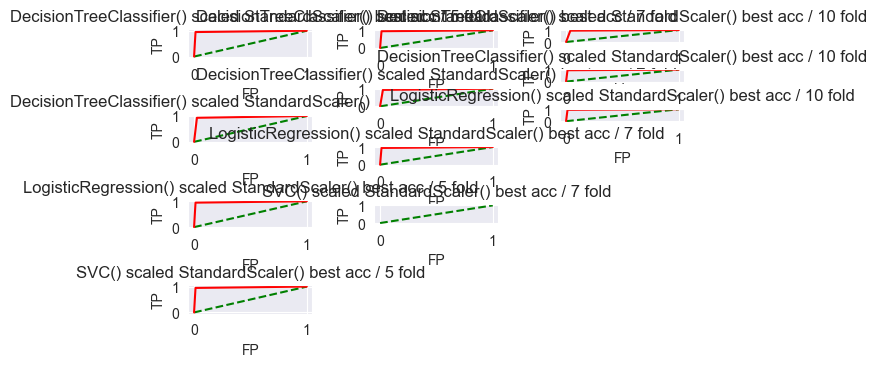

SVC() scaled by StandardScaler() => Best Score: 0.970673, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'} k= 10

DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.963353, Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.957875, Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5} k= 7
DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.957912, Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 5} k= 10

DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.959683, Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.961538, Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5} k= 7
DecisionTreeClassifier() scaled by MinMaxScaler() => Best Score: 0.957946, Parameters: {'criterio

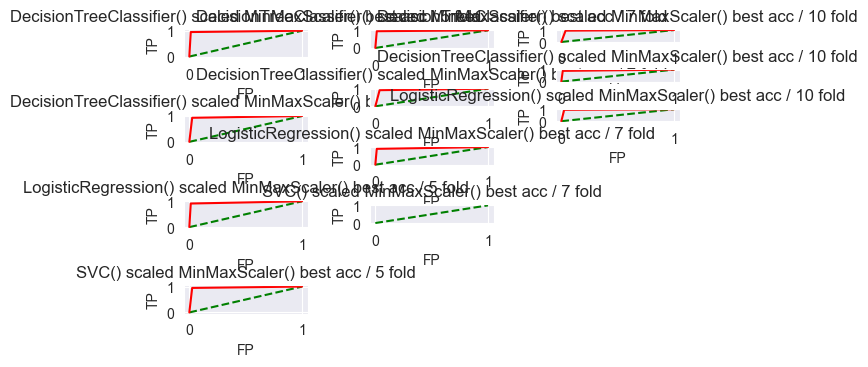

SVC() scaled by MinMaxScaler() => Best Score: 0.970707, Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'} k= 10

DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.961518, Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.957875, Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5} k= 7
DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.956094, Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5} k= 10

DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.961518, Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7} k= 5
DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.961538, Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2} k= 7
DecisionTreeClassifier() scaled by RobustScaler() => Best Score: 0.957946, Parameters: {'criterion': '

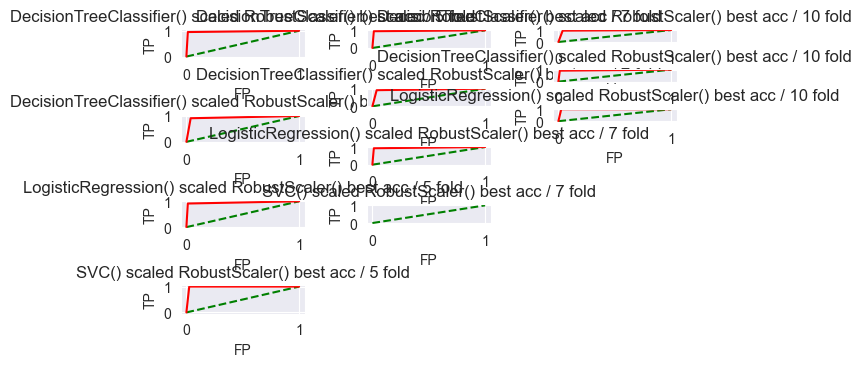

SVC() scaled by RobustScaler() => Best Score: 0.967003, Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'} k= 10

[Train Best Score] : 0.971
[Test Best Score] : 0.985


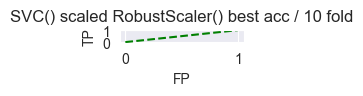

In [13]:
for scaler in scalers:
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    i=0
    k, h = 4,3
    temp = 1
    for model in models:

        for k in Ks:
            grid_search = GridSearchCV(estimator=model, param_grid=dict(models[model].items()), n_jobs=-1, cv=k, scoring='accuracy',error_score=0)
            grid_result = grid_search.fit(X_train, y_train)
            estimator = grid_result.best_estimator_
            y_pred = estimator.predict(X_test)

            fper, tper, thresholds = roc_curve(y_test, y_pred)
            plot_roc_curve(fper, tper, model, k, h, temp, scaler)
            temp += 1
            # summarize results
            print("%s scaled by %s => Best Score: %f, Parameters: %s k= %d" % (model, scaler, grid_result.best_score_, grid_result.best_params_, k))
            if temp == 12:
                plt.show()
                temp = 1
        print()

        train_best_scores[scalers.index(scaler)][i] = grid_result.best_score_
        test_best_scores[scalers.index(scaler)][i] = accuracy_score(y_test, y_pred)

        # get the result graph
        i+= 1



print('[Train Best Score] :', round(float(np.max(train_best_scores)),3))
print('[Test Best Score] :', round(float(np.max(test_best_scores)),3))

plt.show()